# Casestudy MEL : DDA-TMT single cell melanoma data

This is case study DDA-TMT SCMS in  in this paper. The dataset is available at https://massive.ucsd.edu/ProteoSAFe/dataset.jsp?accession=MSV000089159. 

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import set_matplotlib_formats
from matplotlib.lines import Line2D
from pgmpy.estimators import PC
import networkx as nx

# from realms import simulate

set_matplotlib_formats("svg")


/var/folders/sp/pn9txhp11mn2pyld318tpy080000gn/T/ipykernel_44495/1886566139.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg")


The raw spectra were identified and quantified using MaxQuant. The resulting PSMs were than processed using the methods in MSstatsTMT, including normalization across TMT mixtures using a reference channel and summarization of peptide ions into a single value per protein per channel.

### Step 1: Get pilot/historical data from past similar experiment

In [3]:
# data = pd.read_csv('SCMS/data/scmsdata.csv')
from utility import show_protein_abundance_features
protein_abundance_file = "MEL/data/meldataclean.csv"  # Replace with the actual path
data = show_protein_abundance_features(protein_abundance_file)


First few rows of the protein abundance matrix:


,Unnamed: 0,DHX15_HUMAN,G3P_HUMAN,HSPB1_HUMAN,ENOA_HUMAN,NPM_HUMAN,HS90A_HUMAN,HNRPC_HUMAN,HS90B_HUMAN,ANXA5_HUMAN,...,RS23_HUMAN,TYB10_HUMAN,RS4X_HUMAN,H4_HUMAN,RL23_HUMAN,HNRPU_HUMAN,PSME1_HUMAN,EF1A1_HUMAN,PARK7_HUMAN,BioReplicate
0,0,9.368920,10.167968,11.777913,10.920721,10.906010,10.335122,10.634692,11.553578,9.207920,...,11.271160,13.482704,10.378637,10.531847,11.752979,10.405871,9.219097,9.846337,10.133048,0
1,1,9.489853,10.180817,10.818609,10.871440,10.889861,10.396813,10.330118,11.014594,9.597437,...,11.973722,13.070122,10.517606,10.645003,11.238343,10.667812,9.916110,10.187284,10.553502,0
2,2,9.766231,10.706837,11.750412,12.442845,12.427367,11.026080,10.609098,11.076089,11.808549,...,11.030231,12.587978,11.215166,11.626250,10.962162,11.166272,10.285818,10.185965,11.767151,1
3,3,10.048671,9.803506,11.674774,11.818872,11.919689,10.957868,10.552753,11.523332,11.582727,...,11.456930,12.264780,9.961714,11.158386,10.938503,11.007130,9.975372,10.427651,10.365379,1
4,4,10.155918,10.459226,12.510192,11.998972,11.544736,11.230470,10.727446,11.372416,11.370214,...,11.388214,11.661693,10.575094,11.426903,12.067473,11.155149,10.308901,9.994868,10.841175,1



Summary statistics:


,Unnamed: 0,DHX15_HUMAN,G3P_HUMAN,HSPB1_HUMAN,ENOA_HUMAN,NPM_HUMAN,HS90A_HUMAN,HNRPC_HUMAN,HS90B_HUMAN,ANXA5_HUMAN,...,RS23_HUMAN,TYB10_HUMAN,RS4X_HUMAN,H4_HUMAN,RL23_HUMAN,HNRPU_HUMAN,PSME1_HUMAN,EF1A1_HUMAN,PARK7_HUMAN,BioReplicate
count,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,...,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000
mean,297.884083,9.855728,10.026466,10.584304,11.502490,11.693296,10.790998,10.303037,11.293786,10.130298,...,11.695006,13.017091,10.843049,11.828614,11.448060,10.870164,9.679405,10.742467,10.389562,0.500000
std,171.803953,0.836766,1.229318,0.941441,1.144304,1.100614,0.930343,0.813694,0.870039,1.135760,...,0.669182,1.178610,1.034438,1.084016,0.790182,0.867367,1.068507,1.263377,0.971316,0.500433
min,0.000000,7.078714,5.604654,6.918602,7.491112,6.596220,7.859788,6.984590,7.736530,7.071065,...,9.292851,7.026676,5.797775,6.866102,8.417879,6.400731,6.056945,5.356906,7.149216,0.000000
25%,152.250000,9.333430,9.184575,10.034034,10.826952,11.011748,10.180885,9.839522,10.774484,9.311220,...,11.278980,12.462724,10.292506,11.316896,10.952559,10.409697,8.929836,10.069013,9.765205,0.000000
50%,297.500000,9.889662,10.054170,10.673858,11.624076,11.760784,10.808268,10.358694,11.387239,10.163023,...,11.753656,13.192271,10.872665,11.937193,11.540077,10.956504,9.778922,10.857273,10.426613,0.500000
75%,444.750000,10.399402,10.936136,11.180441,12.322899,12.460075,11.528997,10.801222,11.889873,10.935234,...,12.144368,13.794674,11.522288,12.467406,11.997538,11.388979,10.428900,11.601812,11.086683,1.000000
max,627.000000,14.115169,13.356127,13.398974,14.772624,14.926437,13.347250,15.225679,13.859288,14.731980,...,14.047837,16.236685,13.692487,14.520518,13.813534,13.328950,12.860108,14.001458,12.918065,1.000000



Column names and data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 35 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    578 non-null    int64  
 1   DHX15_HUMAN   578 non-null    float64
 2   G3P_HUMAN     578 non-null    float64
 3   HSPB1_HUMAN   578 non-null    float64
 4   ENOA_HUMAN    578 non-null    float64
 5   NPM_HUMAN     578 non-null    float64
 6   HS90A_HUMAN   578 non-null    float64
 7   HNRPC_HUMAN   578 non-null    float64
 8   HS90B_HUMAN   578 non-null    float64
 9   ANXA5_HUMAN   578 non-null    float64
 10  H14_HUMAN     578 non-null    float64
 11  CH60_HUMAN    578 non-null    float64
 12  KPYM_HUMAN    578 non-null    float64
 13  ENPL_HUMAN    578 non-null    float64
 14  PGAM1_HUMAN   578 non-null    float64
 15  NUCL_HUMAN    578 non-null    float64
 16  RL13_HUMAN    578 non-null    float64
 17  CALR_HUMAN    578 non-null    float64
 18  

None

### Step2(optional): Prior Knowledge Network creation 


The figure below shows the prior knowledge network queried from INDRA. It comprises 1300 nodes, connected by a total of 6567 directed edges.

INDRA data loaded successfully from MEL/network/indra.tsv


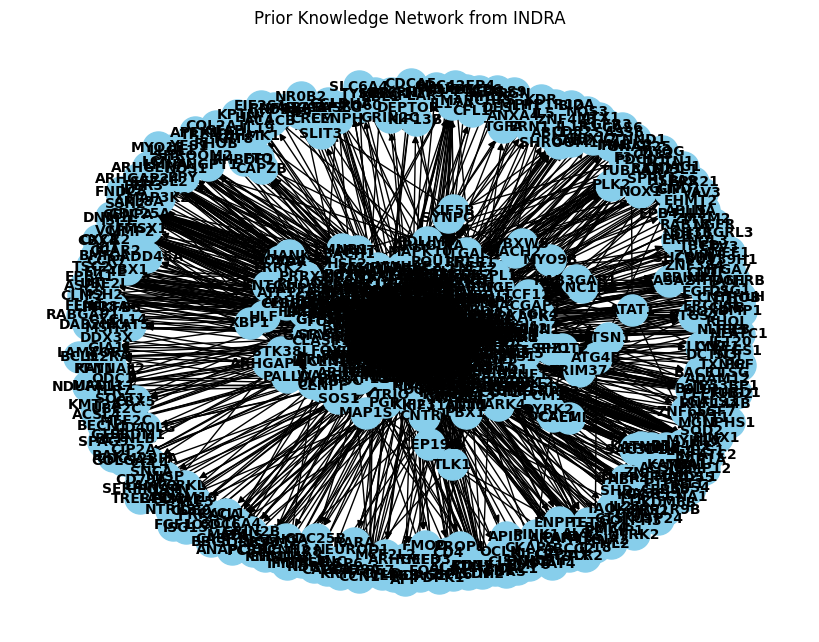

In [14]:
from makepkn import plot_indra
indra_file = "MEL/network/indra.tsv"  # Replace with the actual path
plot_indra(indra_file)

The figure is combined graph obtained using combination of pkn from INDRA and  structure learning using PC algorithm

<div>
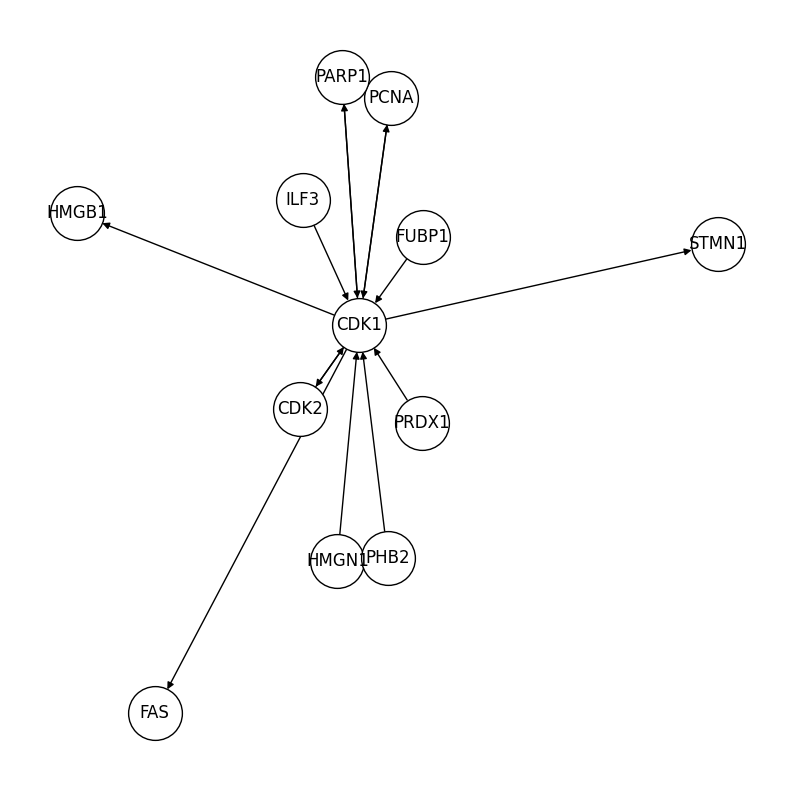
</div>


Correlation matrix computed successfully.


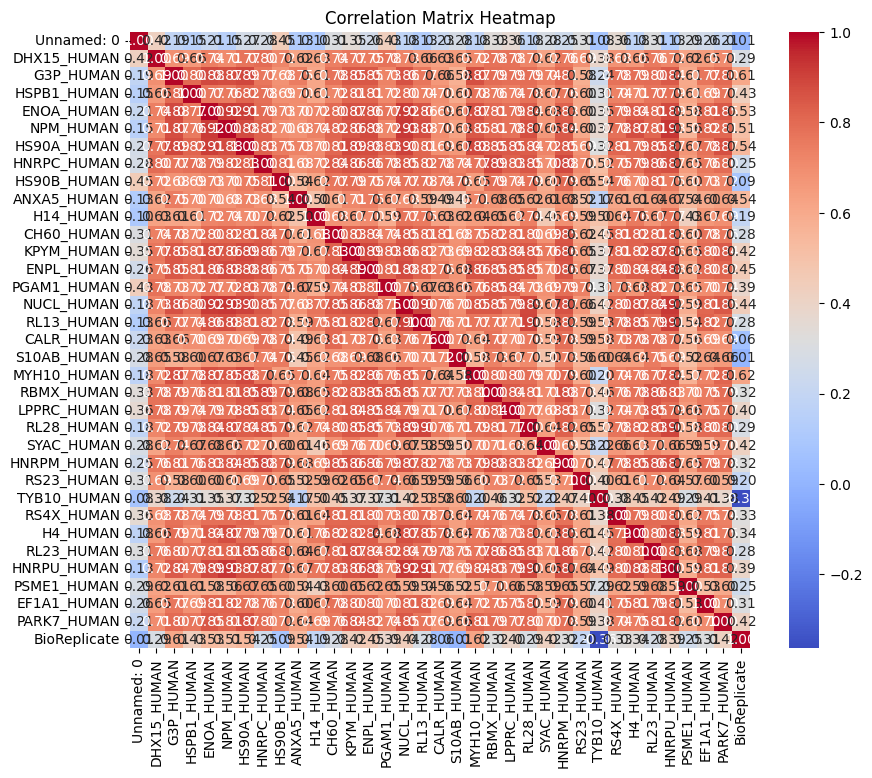

In [15]:
from evaluate import plot_correlation_matrix
plot_correlation_matrix(data)

## Step 3: Simulating realistic data using copula model 

In [14]:
dataset = df_with_0
# dataset = egf
from copulas.multivariate import GaussianMultivariate

for i in range(100):
    model = utility.simulatecopula(dataset)
    synthetic = utility.sample(model,len(dataset))
#     synthetic.to_csv('crc/copula/crc0_gm_copula_'+str(i)+'.csv',index=False)


NameError: name 'df_with_0' is not defined

## Step 4: Evaluating realism

#### Visual Metrics

In [ ]:
import plotly.express as px
# df = px.data.tips()
df = sim
fig = px.histogram(df, x="CP" , color="Condition",facet_col="Method",
                  marginal="box", histnorm='probability density')
fig.show()

In [ ]:
protname = "A0A0C4DH73"

sns.boxplot(data=df_sorted, x="Condition", y=protname)

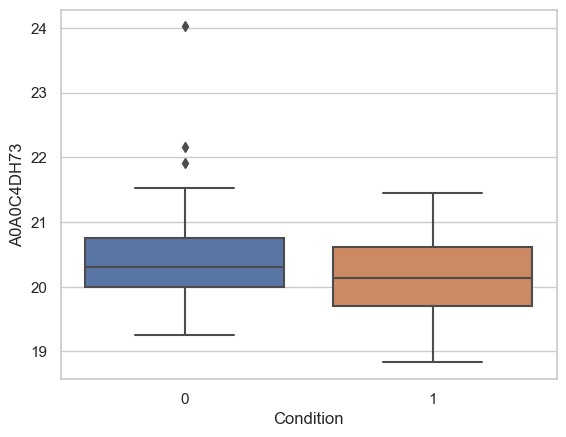

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.cluster.hierarchy as sch
import numpy as np
# df = data0
df = data1
X = df.corr().values
X[np.isnan(X)]= 0
d = sch.distance.pdist(X)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [df.columns.tolist()[i] for i in list((np.argsort(ind)))]
df = df.reindex(columns, axis=1)

plot_corr(df, size=18)
plt.savefig('data_plotreal.png')

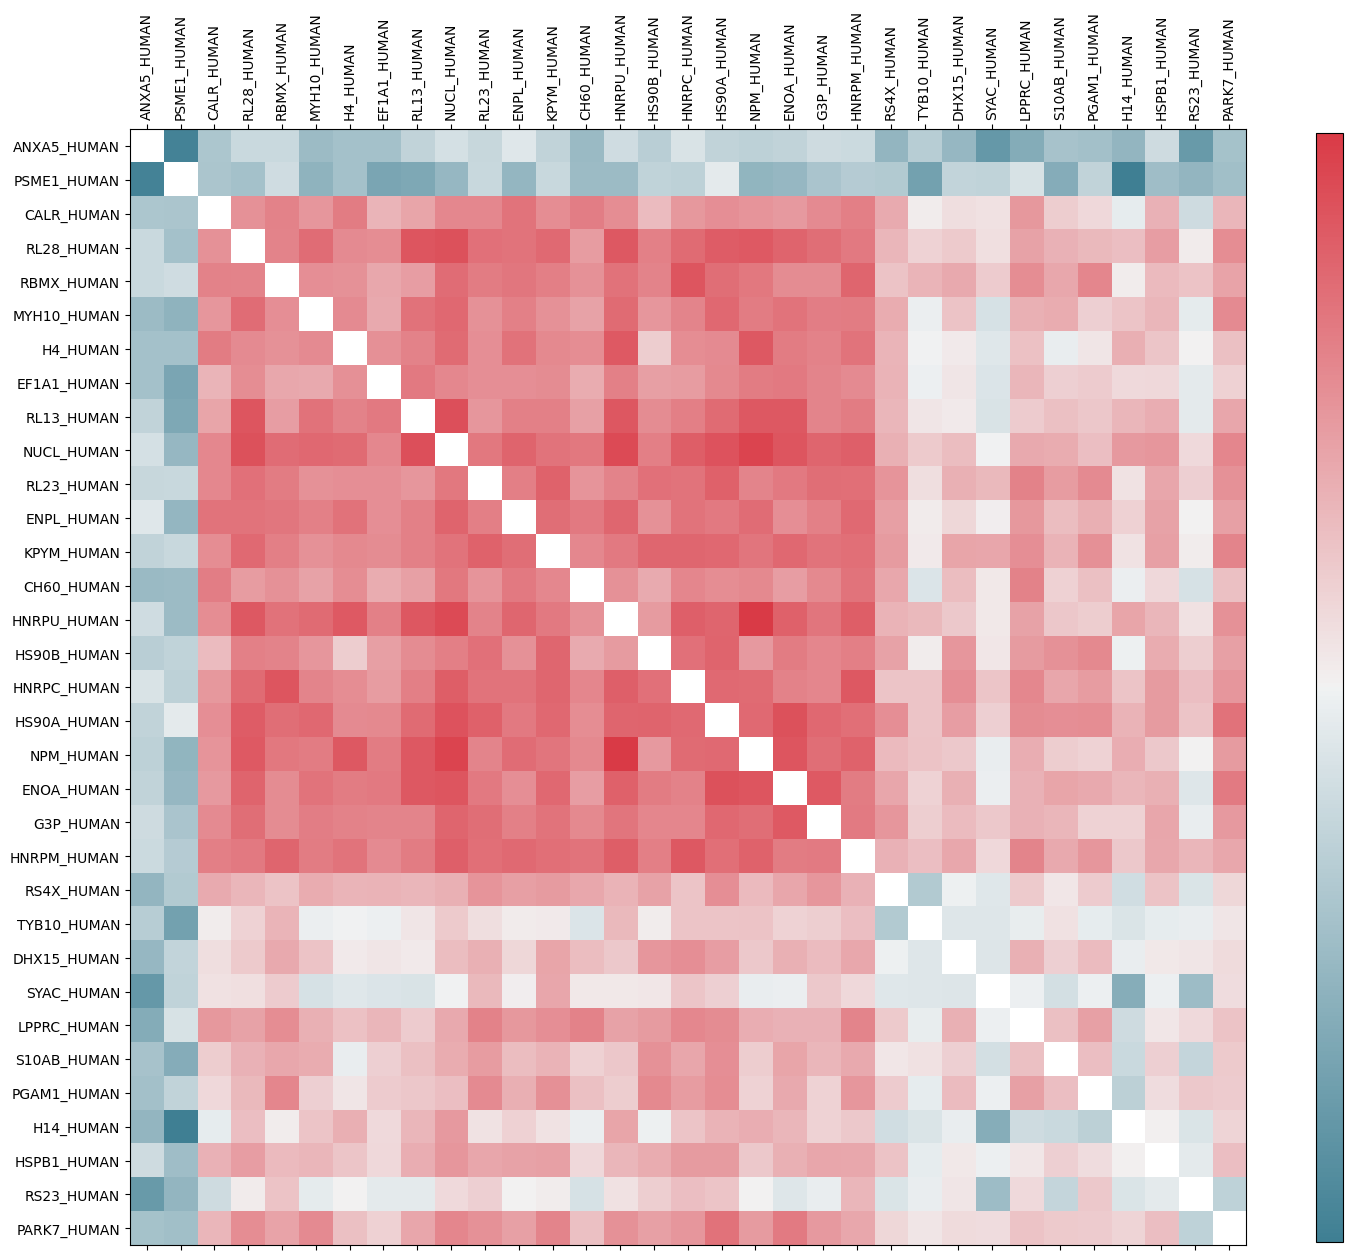


In [ ]:
fake = data11
fake = fake.reindex(columns, axis=1)
plot_corr(fake,size=18)
plt.savefig('data_plotsim.png')

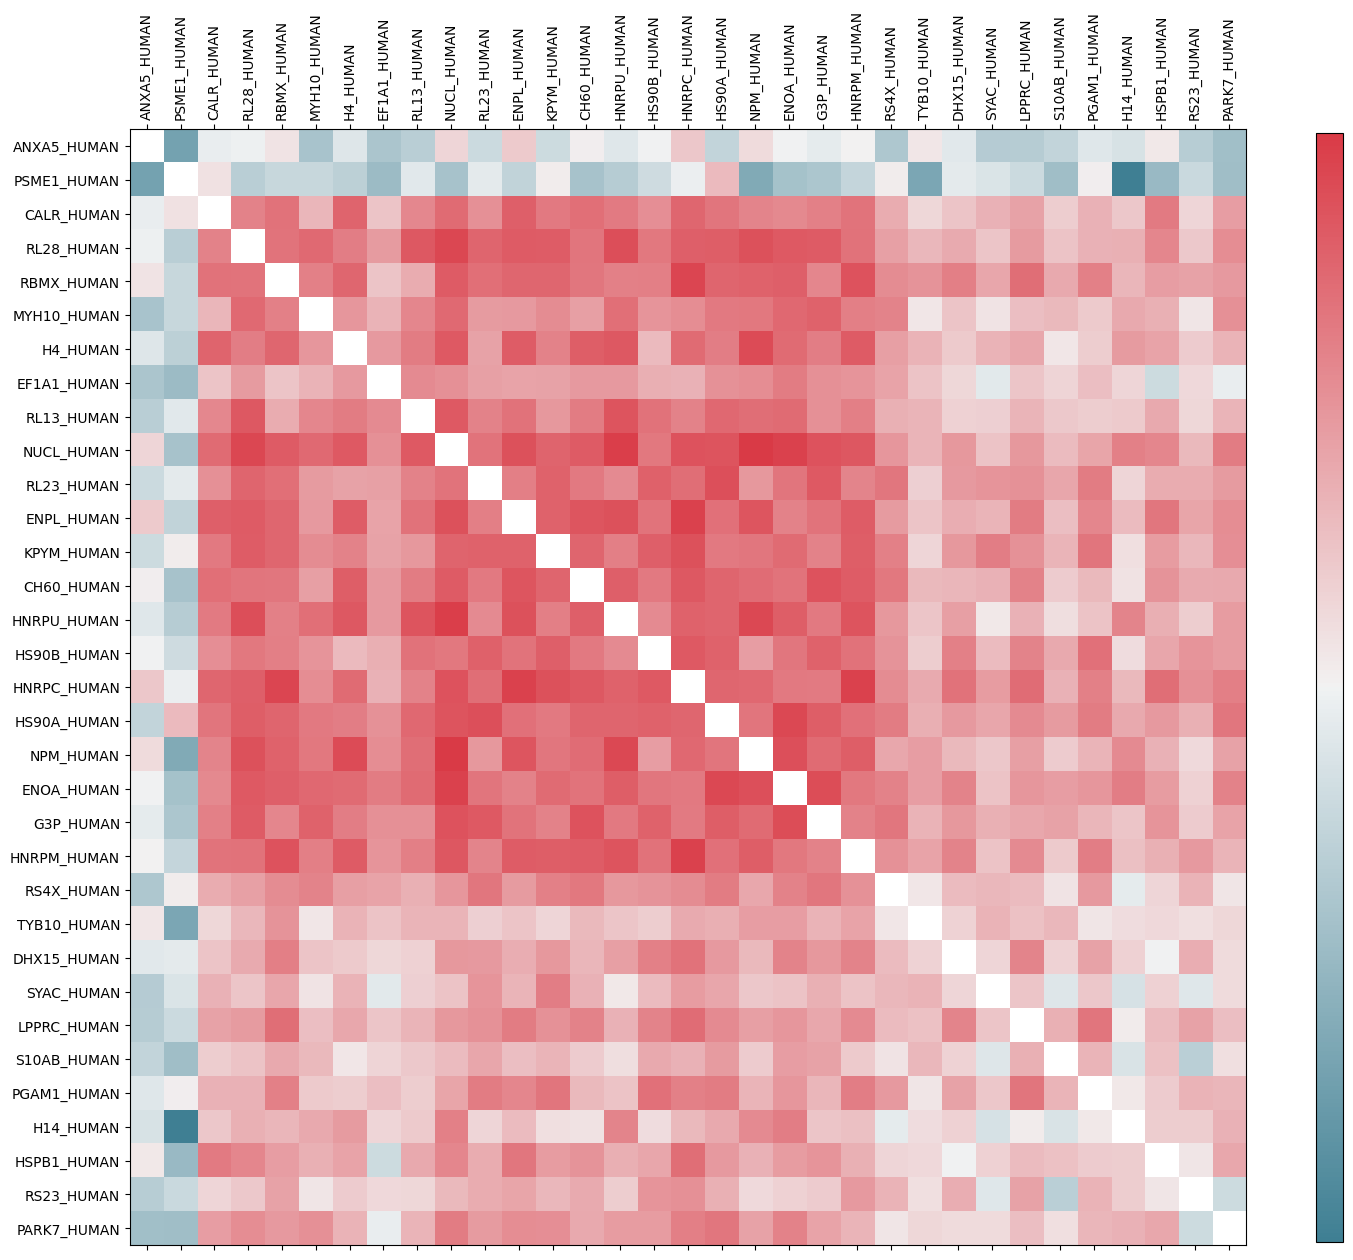

#### Similarity Score

In [ ]:
from table_evaluator import load_data, TableEvaluator
table_evaluator.evaluate(target_col='Condition')


## Step 5: Selecting sample size appropriate for downstream application

#### Class Prediction

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

filepath = 'pdacdia/data/'
data0 = pd.read_csv(filepath +'test_pdac15dia_0.csv')
data0 = data0.drop('Sample type',axis=1)
data1 = pd.read_csv(filepath +'test_pdac15dia_1.csv')
data1 = data1.drop('Sample type',axis=1)
data0['Condition']=0
data1['Condition']=1
data = pd.concat([data0,data1])
rdata = data
# Set up dictionaries to store min and max accuracies for each sample size

# filepath = 'pdac/'
# filepath = 'mel/'
# filepath = 'crc/'
# filepath = 'pdacsrm/'
filepath = 'pdacdia/'
# Set the sample sizes
sample_sizes = [5,10,20,30,40,50,60,70,80,90,100]
# sample_sizes = [5, 10, 20, 30, 40, 50, 100]
# sample_sizes = [100,300,500]
print("Per-protein")
min_accuracies = []
max_accuracies = []
accuracies = []
# Call the function for each sample size
for sample_size in sample_sizes:
    simulated_data0_pp = pd.read_csv(filepath+'perprotein/combined_train0.csv')
    simulated_data1_pp = pd.read_csv(filepath+'perprotein/combined_train1.csv')
    # Add a condition column
    simulated_data0_pp['Condition'] = 0
    simulated_data1_pp['Condition'] = 1

    # Concatenate the datasets
    simulated_data = pd.concat([simulated_data0_pp, simulated_data1_pp], ignore_index=True)
#         simulated_data = rdata
    # Run your analysis (e.g., Random Forest)
    accuracy, mina, maxa = run_random_forest(simulated_data, sample_size, rdata,False)

    accuracies.append(accuracy)
    
    min_accuracies.append(mina)
    max_accuracies.append(maxa) 

    print(f'Sample Size: {sample_size}, Average Accuracy: {accuracy:.4f}, Min Accuracy: {mina:.4f}, Max accuracy: {maxa:.4f}')


In [ ]:
import matplotlib.pyplot as plt
import matplotlib

crc_data_val = pdac_data_val
# Plotting
# matplotlib.rcParams.update({'font.size': 22})
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.figure(figsize=(12, 8))
# Plot REAL
plt.plot(crc_data_val['Sample Size'], crc_data_val['Accuracy'],label='Experimental',marker='o', color='red')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['min'], crc_data_val['max'], color='red', alpha=0.3)


# Plot PP
plt.plot(crc_data_val['Sample Size'], crc_data_val['PP Accuracy'], label='PP',marker='o', color='blue')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['PP min'], crc_data_val['PP max'], color='blue', alpha=0.3)

# Plot CO
plt.plot(crc_data_val['Sample Size'], crc_data_val['CO Accuracy'], label='CO',marker='o', color='orange')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['CO min'], crc_data_val['CO max'], color='orange', alpha=0.3)


# Plot TVAE
plt.plot(crc_data_val['Sample Size'], crc_data_val['TVAE Accuracy'], label='TVAE',marker='o', color='green')
plt.fill_between(crc_data_val['Sample Size'], crc_data_val['TVAE min'], crc_data_val['TVAE max'], color='green', alpha=0.3)

# Labels and legend
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
# plt.title('Accuracy vs Sample Size for Different Methods')
# plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Show plot
# plt.grid(True)
plt.show()


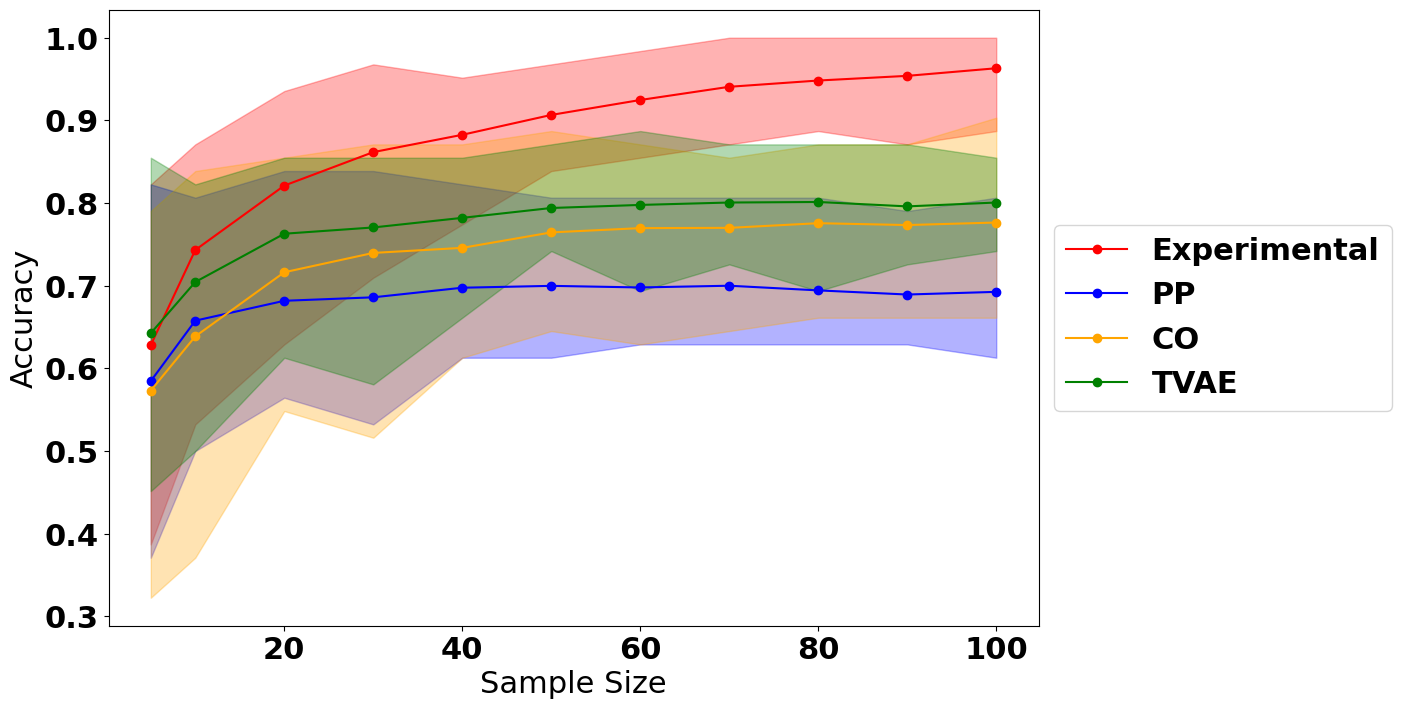

##### Class Discovery

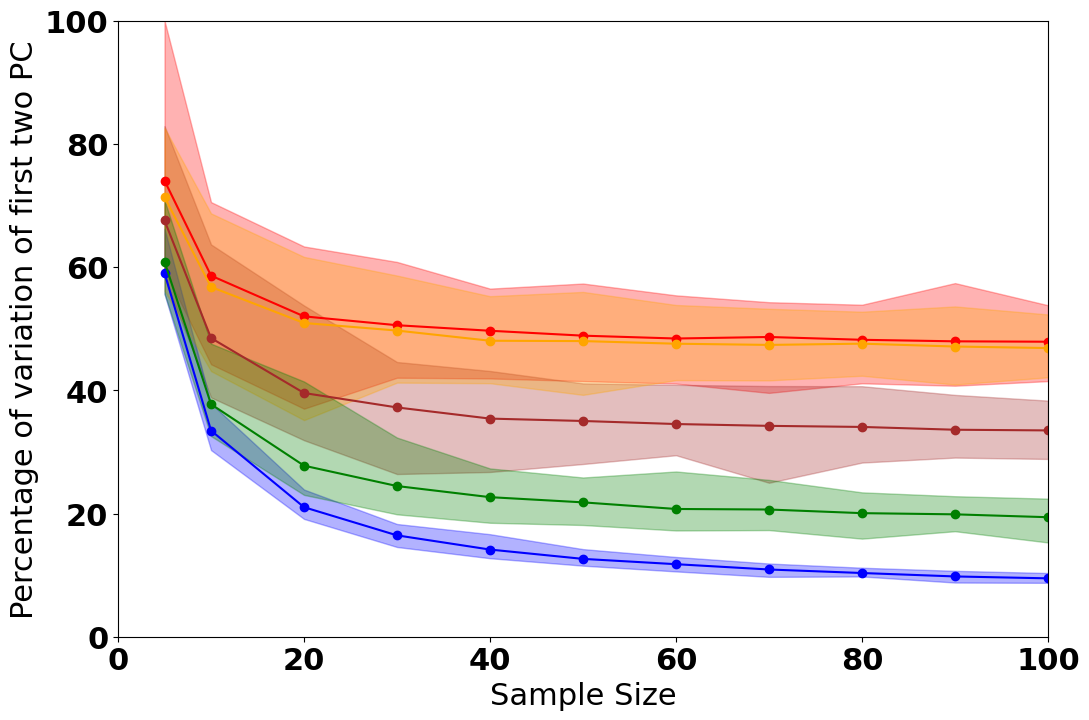

##### Class Comparison

##### Scalability analysis